In [1]:
import os 
import cv2
import numpy as np 
from tqdm import tqdm 

## Data Preprocessing 

In [5]:
REBUILD_DATA = True

class DogsVSCats():
    IMG_SIZE = 50
    Cats = 'PetImages/Cat'
    Dogs = "PetImages/Dog"
    Labels = {Cats: 0, Dogs: 1}
    training_data = []
    catcount =0 
    dogcount = 0
    
    def make_training_data(self):
        for label in self.Labels:
            print(label)
            for f in tqdm(os.listdir(label)):
                
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.Labels[label]]])
                    if label == self.Cats:
                        self.catcount +=1 
                    elif label == self.Dogs:
                        self.dogcount +=1 
                        
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:", self.dogcount)              


In [6]:
if REBUILD_DATA:
    dogvscats = DogsVSCats()
    dogvscats.make_training_data()

PetImages/Cat


100%|███████████████████████████████████| 12501/12501 [00:10<00:00, 1218.17it/s]


PetImages/Dog


100%|███████████████████████████████████| 12501/12501 [00:11<00:00, 1068.70it/s]
/Users/chiyum/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


In [7]:
train_data = np.load("training_data.npy", allow_pickle = True)

In [8]:
print(len(train_data))

24946


In [9]:
print(train_data[1])

[array([[  5,   4,   4, ...,   4,   0,  33],
        [  4,   4,   6, ...,   2,   1,   0],
        [  5,   3,   5, ...,   3,   3,   2],
        ...,
        [107, 125, 152, ...,  28,  25,  27],
        [103, 118, 150, ...,  27,  27,  28],
        [ 90, 114, 152, ...,  28,  26,  26]], dtype=uint8) array([1., 0.])]


<function matplotlib.pyplot.show(close=None, block=None)>

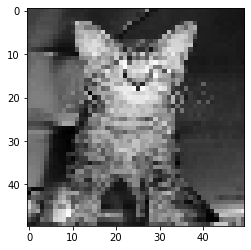

In [12]:
import matplotlib.pyplot as plt

plt.imshow(train_data[0][0], 
          cmap= "gray")
plt.show

In [13]:
train_data[2][1]

array([0., 1.])

## Implementing CNN 

In [32]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 5x5 kernel size or windows
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))        
        # to calculate the dimension from convolution 
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x 
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim = 1)


In [33]:
net = Net()

In [34]:
import torch.optim as optim 

optimizer = optim.Adam(net.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in train_data]).view(-1, 50, 50)
# scaling the boundary
X = X/255.0
y = torch.Tensor([i[1] for i in train_data])

val_pct = 0.1 
val_size = int(len(X)*val_pct)
print(val_size)

2494


In [35]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [37]:
# lower down the batch size if hitting a memory error 
BATCH_SIZE = 100
epochs = 1

for epoch in range(epochs):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_x = train_X[i:i+BATCH_SIZE].view(-1, 1, 50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()
        outputs = net(batch_x)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

100%|█████████████████████████████████████████| 225/225 [01:52<00:00,  2.01it/s]

tensor(0.1519, grad_fn=<MseLossBackward0>)


In [38]:
correct = 0
total = 0 
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
                  real = torch.argmax(test_y[i])
                  out = net(test_X[i].view(-1, 1, 50, 50))[0]
                  predicted = torch.argmax(out)
                  if predicted == real:
                      correct +=1 
                  total +=1 
print("Accuracy:", round(correct/total, 3))

100%|██████████████████████████████████████| 2494/2494 [00:04<00:00, 543.06it/s]

Accuracy: 0.743


In [39]:
torch.cuda.is_available()

False